In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# load datasets
data = {'MOOC': torch.load("data/act-mooc/graph.pt"), 
        'Junyi': torch.load("data/junyi/graph.pt")}

In [28]:
def get_statistics(data):
    num_users = data['user'].node_id.size(0)
    num_resources = data['resource'].node_id.size(0)
    num_features_interaction = data[('user', 'accesses', 'resource')].edge_attr.size(1)
    avg_interactions_per_user = data[('user', 'accesses', 'resource')].edge_index.size(1) / num_users
    avg_interactions_per_resource = data[('user', 'accesses', 'resource')].edge_index.size(1) / num_resources
    
    df = pd.DataFrame({
        'user': data[('user', 'accesses', 'resource')].edge_index[0].tolist(),
        'resource': data[('user', 'accesses', 'resource')].edge_index[1].tolist(),
        'timestamp': data[('user', 'accesses', 'resource')].time.tolist(),
        'dropout': data[('user', 'accesses', 'resource')].edge_y.tolist()
    })
    # Avg user lifetime in days
    grouped = df.groupby('user')['timestamp'].agg(['max', 'min'])
    grouped['time_span'] = grouped['max'] - grouped['min']
    avg_time_span_per_user_in_days = grouped['time_span'].mean() / (3600 * 24)
    
    # Avg number of interactions per user+accessed resource
    grouped = df.groupby('user')['resource'].value_counts()
    per_user_mean = grouped.groupby('user').mean()
    avg_interactions_per_user_resource = per_user_mean.mean()

    # Plot a histogram of the occurrence counts
    occurrences = df.groupby(['user', 'resource']).size()
    plt.figure(figsize=(10,6))
    occurrences.hist(bins=occurrences.max(), edgecolor='black')
    plt.title('Histogram of Occurrence Counts')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Number of UserID-TargetID Combinations')
    plt.show()
    
    # Average times a user changes their state to dropout
    df_no_duplicates = df.drop_duplicates(subset=['user', 'timestamp'])
    dropout_edges = df_no_duplicates['dropout'].sum()
    avg_user_dropout = df_no_duplicates['dropout'].sum() / num_users
    
    return {
        "Number of users": num_users,
        "Number of resources": num_resources,
        "Number of features for each interaction": num_features_interaction,
        "Avg. number of interactions per user": avg_interactions_per_user,
        "Avg. number of interactions per resource": avg_interactions_per_resource,
        "Avg. number of interactions per user and accessed resource": avg_interactions_per_user_resource,
        "Avg. lifetime per user [days]": avg_time_span_per_user_in_days,
        "Dropout events per user": avg_user_dropout
    }


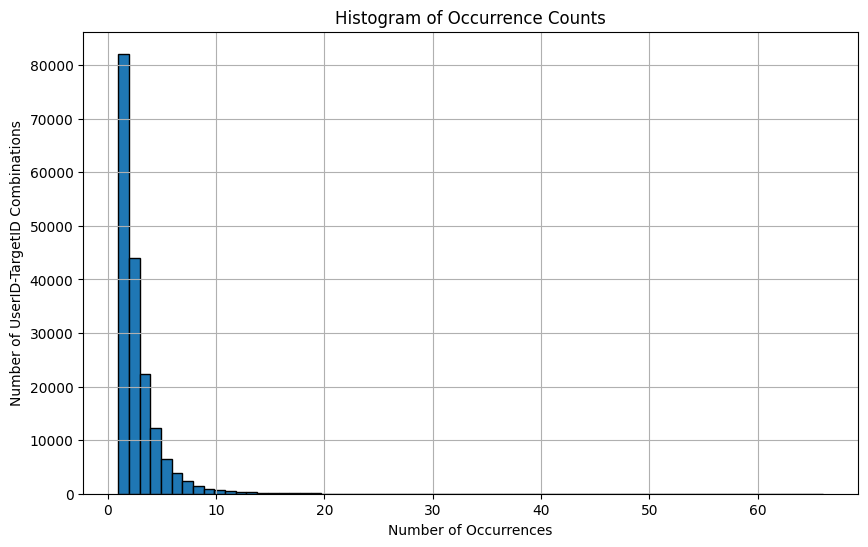

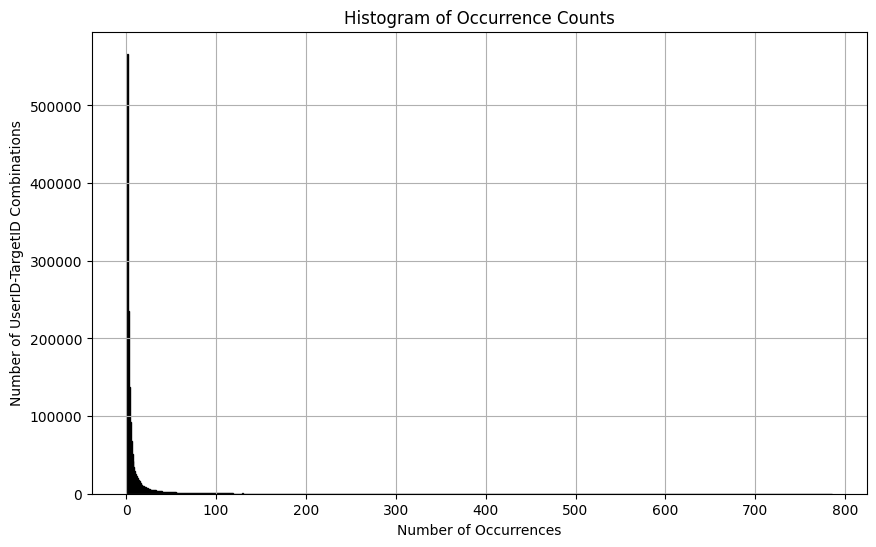

,Number of users,Number of resources,Number of features for each interaction,Avg. number of interactions per user,Avg. number of interactions per resource,Avg. number of interactions per user and accessed resource,Avg. lifetime per user [days],Rate of dropout events
MOOC,7047,97,4,58.43,4244.84,2.1,11.18,0.57
Junyi,72758,1702,6,222.89,9528.38,7.14,70.81,0.93


In [30]:
# Compute the statistics for each dataset
statistics = {key: get_statistics(value) for key, value in data.items()}

df = pd.DataFrame(statistics).T

df = df.convert_dtypes().round(2)

df

In [33]:
latex_code = df.T.to_latex(float_format="%.1f", column_format="lrr")
print(latex_code)

\begin{tabular}{lrr}
\toprule
 & MOOC & Junyi \\
\midrule
Number of users & 7047 & 72758 \\
Number of resources & 97 & 1702 \\
Number of features for each interaction & 4 & 6 \\
Avg. number of interactions per user & 58.4 & 222.9 \\
Avg. number of interactions per resource & 4244.8 & 9528.4 \\
Avg. number of interactions per user and accessed resource & 2.1 & 7.1 \\
Avg. lifetime per user [days] & 11.2 & 70.8 \\
Rate of dropout events & 0.6 & 0.9 \\
\bottomrule
\end{tabular}



In [21]:
data['Junyi'][('user', 'accesses', 'resource')].edge_y.sum()

tensor(0)